# Validation Analysis - Figures

In [1]:
from pathlib import Path

import pandas as pd
import geopandas as gpd
import numpy as np
import scipy
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
SAVE_FIGS = False
REPO_ROOT = Path('/Users/rwegener/repos/chesapeake_mhw')

In [3]:
# MUR and Geopolar anomaly compared to in situ anomaly
# wq_sst = pd.read_csv('../data/AllTemps_SSTAnomaly.csv')
# 'Anomaly_values_satellite_cbp.csv'
# OLD PATTERN
# path = os.path.join(REPO_ROOT, 'data/processed', 'raw_values_satellites_CBPstations_filtered.csv')
# NEW PATTERN
path = REPO_ROOT / 'data/processed/SST_satellites_cbp_stations.csv'
path = REPO_ROOT / 'data/processed/SST_satellites_cbp_stations_Feb3(naivemonthly).csv'
wq_sst = pd.read_csv(path, parse_dates=[3])

In [4]:
path = REPO_ROOT / 'data/processed/SSTanom_satellites_cbp_stations.csv'
path = REPO_ROOT / 'data/processed/SSTanom_satellites_cbp_stations_Feb3(naivemonthly).csv'
wq_anom = pd.read_csv(path, parse_dates=[3])

In [5]:
wq_sst

,Station,Latitude,Longitude,SampleDate,sst_cbp,geopolar,mur,ostia
0,1AAUA001.39,38.40000,-77.32000,2007-03-22,8.300,4.00000,NaN,2.970001
1,1AAUA001.39,38.40000,-77.32000,2007-06-18,26.200,21.97000,NaN,20.510010
2,1AAUA001.39,38.40000,-77.32000,2007-10-29,14.500,18.01999,NaN,17.010010
3,1AAUA001.39,38.40000,-77.32000,2007-12-10,5.200,10.75000,NaN,11.369995
4,1AAUA001.39,38.40000,-77.32000,2008-02-04,4.900,3.67001,NaN,4.000000
...,...,...,...,...,...,...,...,...
35723,YRK031.24,37.50465,-76.79252,2008-07-22,29.460,NaN,27.75699,NaN
35724,YRK031.24,37.50465,-76.79252,2008-08-22,26.455,NaN,26.09100,NaN
35725,YRK031.24,37.50465,-76.79252,2008-09-17,25.105,NaN,23.48300,NaN
35726,YRK031.24,37.50465,-76.79252,2008-10-16,21.134,NaN,21.22501,NaN


In [6]:
wq_anom

,Station,Latitude,Longitude,SampleDate,anom_cbp,anom_geopolar,anom_mur,anom_ostia
0,CB2.1,39.44149,-76.02599,2003-01-15,-2.03846,-0.78302,-0.83598,NaN
1,CB2.1,39.44149,-76.02599,2003-03-12,-4.00000,-4.33597,-5.73561,NaN
2,CB2.1,39.44149,-76.02599,2003-04-09,-5.91200,-3.31286,-7.00755,NaN
3,CB2.1,39.44149,-76.02599,2003-04-23,0.28800,-1.58285,-5.31157,NaN
4,CB2.1,39.44149,-76.02599,2003-05-07,-2.89259,-5.61901,-8.18635,NaN
...,...,...,...,...,...,...,...,...
12670,WT8.3,38.84250,-76.53410,2022-08-09,2.21739,2.52287,NaN,2.358888
12671,WT8.3,38.84250,-76.53410,2022-09-13,2.12045,1.81140,NaN,1.742271
12672,WT8.3,38.84250,-76.53410,2022-10-12,-0.52609,-1.34437,NaN,-1.683730
12673,WT8.3,38.84250,-76.53410,2022-11-14,1.79500,3.03127,NaN,2.998352


In [7]:
len(wq_anom.groupby('Station').count())

48

In [8]:
wq_anom[wq_anom.SampleDate == '2003-01-15']

,Station,Latitude,Longitude,SampleDate,anom_cbp,anom_geopolar,anom_mur,anom_ostia
0,CB2.1,39.44149,-76.02599,2003-01-15,-2.03846,-0.78302,-0.83598,NaN
297,CB2.2,39.34873,-76.17579,2003-01-15,-2.02143,-0.71632,-1.05934,NaN
597,CB3.1,39.24950,-76.24050,2003-01-15,-2.24286,-0.95987,-1.23249,NaN
11216,WT5.1,39.21309,-76.52254,2003-01-15,-0.90500,-1.62286,-1.69411,NaN


## Pre-processing

### Raw SST

In [12]:
wq_sst['geopolar_err'] = wq_sst['geopolar'] - wq_sst['sst_cbp']
wq_sst['mur_err'] = wq_sst['mur'] - wq_sst['sst_cbp']
wq_sst['ostia_err'] = wq_sst['ostia'] - wq_sst['sst_cbp']

In [13]:
mur_nonan = wq_sst[~wq_sst['mur'].isnull()][['sst_cbp', 'mur']]
geop_nonan = wq_sst[~wq_sst['geopolar'].isnull()][['sst_cbp', 'geopolar']]
ostia_nonan = wq_sst[~wq_sst['ostia'].isnull()][['sst_cbp', 'ostia']]

### SST Anomaly

In [14]:
wq_anom['geopanom_err'] = wq_anom['anom_geopolar'] - wq_anom['anom_cbp']
wq_anom['muranom_err'] = wq_anom['anom_mur'] - wq_anom['anom_cbp']
wq_anom['ostiaanom_err'] = wq_anom['anom_ostia'] - wq_anom['anom_cbp']

In [15]:
muranom_nonan = wq_anom[~wq_anom['anom_mur'].isnull()][['anom_cbp', 'anom_mur']]
geopanom_nonan = wq_anom[~wq_anom['anom_geopolar'].isnull()][['anom_cbp', 'anom_geopolar']]
ostiaanom_nonan = wq_anom[~wq_anom['anom_ostia'].isnull()][['anom_cbp', 'anom_ostia']]

## Compute Mean Bias

In [16]:
def compute_mean_bias(error_series, name='no_name_given'):
    err = error_series.dropna()
    mean_bias = err.sum() / len(err)
    print('Mean bias of', name, 'is: ', np.round(mean_bias, 4))
    return mean_bias

### Raw SST

In [17]:
mur_bias = compute_mean_bias(wq_sst.mur_err, 'MUR')
geopolar_bias = compute_mean_bias(wq_sst.geopolar_err, 'Geo-Polar')
ostia_bias = compute_mean_bias(wq_sst.ostia_err, 'OSTIA')

Mean bias of MUR is:  -0.5413
Mean bias of Geo-Polar is:  -0.5211
Mean bias of OSTIA is:  -0.522


### SST Anomaly

In [18]:
mur_anom_bias = compute_mean_bias(wq_anom.anom_mur - wq_anom.anom_cbp, 'MUR')
geopolar_anom_bias = compute_mean_bias(wq_anom.anom_geopolar - wq_anom.anom_cbp, 'Geo-Polar')
ostia_anom_bias = compute_mean_bias(wq_anom.anom_ostia - wq_anom.anom_cbp, 'OSTIA')

Mean bias of MUR is:  -0.6063
Mean bias of Geo-Polar is:  -0.194
Mean bias of OSTIA is:  -0.2656


## Compute $R^2$

### Raw SST

In [19]:
_slope, _inter, r_val, _p_val, _std_err = scipy.stats.linregress(
    mur_nonan.sst_cbp, mur_nonan.mur)

print('MUR: r squared', r_val**2)

MUR: r squared 0.9536011614902679


In [20]:
_slope, _inter, r_val, _p_val, _std_err = scipy.stats.linregress(
    geop_nonan.sst_cbp, geop_nonan.geopolar)

print('Geo-Polar: r squared', r_val**2)

Geo-Polar: r squared 0.9647551809636452


In [21]:
_slope, _inter, r_val, _p_val, _std_err = scipy.stats.linregress(
    ostia_nonan.sst_cbp, ostia_nonan.ostia)

print('OSTIA: r squared', r_val**2)

OSTIA: r squared 0.9629317766861487


### SST Anomaly

In [22]:
_slope, _inter, r_val, _p_val, _std_err = scipy.stats.linregress(
    muranom_nonan.anom_cbp, muranom_nonan.anom_mur)

print('MUR: r squared', r_val**2)

MUR: r squared 0.4804890671416334


In [23]:
_slope, _inter, r_val, _p_val, _std_err = scipy.stats.linregress(
    geopanom_nonan.anom_cbp, geopanom_nonan.anom_geopolar)

print('Geo-Polar: r squared', r_val**2)

Geo-Polar: r squared 0.6426376010990072


In [24]:
_slope, _inter, r_val, _p_val, _std_err = scipy.stats.linregress(
    ostiaanom_nonan.anom_cbp, ostiaanom_nonan.anom_ostia)

print('OSTIA: r squared', r_val**2)

OSTIA: r squared 0.6048551006596399


## Computing slope and intercept values with robust regression

[https://www.statsmodels.org/stable/rlm.html](https://www.statsmodels.org/stable/rlm.html)

References:
- SO [example](https://stackoverflow.com/questions/46606082/using-huber-scale-and-location-estimator-in-statsmodel)
- Penn State [course webpage](https://online.stat.psu.edu/stat501/lesson/t/t.1/t.1.1-robust-regression-methods)
- statsmodels [RLMdocs](https://www.statsmodels.org/stable/generated/statsmodels.robust.robust_linear_model.RLM.html)
- [graphs](https://www.statsmodels.org/stable/rlm_techn1.html) for the weight function
- SO [post](https://stackoverflow.com/questions/31655196/how-to-get-r-squared-for-robust-regression-rlm-in-statsmodels) arguing against R2 when using robust regression

In [27]:
def robust_regression(x_values, y_values, name='no_name_given'):
    model = sm.RLM(y_values, sm.add_constant(x_values), 
                   M=sm.robust.norms.TukeyBiweight())
    results = model.fit()
    try:
        # attempt to retrieve value for SST
        rlm_slope = results.params.sst_cbp
    except AttributeError:
        # if it doesn't exist assume anom and retrieve anom_cbp params
        rlm_slope = results.params.anom_cbp
    rlm_inter = results.params.const
    print(name, 'slope', np.round(rlm_slope, 4), 
          'and intercept', np.round(rlm_inter, 4))
    return rlm_slope, rlm_inter

### Raw SST

In [28]:
mur_slope, mur_inter = robust_regression(mur_nonan.sst_cbp, mur_nonan.mur, 'MUR')
geopolar_slope, geopolar_inter = robust_regression(
    geop_nonan.sst_cbp, geop_nonan.geopolar, 'Geo-Polar')
ostia_slope, ostia_inter = robust_regression(
    ostia_nonan.sst_cbp, ostia_nonan.ostia, 'OSTIA')

MUR slope 0.9817 and intercept 0.1451
Geo-Polar slope 0.9742 and intercept 0.1498
OSTIA slope 0.9714 and intercept 0.2322


### SST Anomaly

In [29]:
muranom_slope, muranom_inter = robust_regression(
    muranom_nonan.anom_cbp, muranom_nonan.anom_mur, 'MUR')
geopanom_slope, geopanom_inter = robust_regression(
    geopanom_nonan.anom_cbp, geopanom_nonan.anom_geopolar, 'Geo-Polar')
ostiaanom_slope, ostiaanom_inter = robust_regression(
    ostiaanom_nonan.anom_cbp, ostiaanom_nonan.anom_ostia, 'OSTIA')

MUR slope 0.8388 and intercept -0.3251
Geo-Polar slope 0.7926 and intercept -0.1692
OSTIA slope 0.7575 and intercept -0.1711


## Compute RMSE

In [30]:
def compute_rmse(error_series, name='no_name_given'):
    rmse = np.sqrt((error_series**2).sum() / error_series.count())
    print('RMSE', name, ':', np.round(rmse, 4))
    return rmse

### Raw SST

In [73]:
mur_rmse = compute_rmse(wq_sst.mur_err, 'MUR')
gepolar_rmse = compute_rmse(wq_sst.geopolar_err, 'Geo-Polar')
ostia_rmse = compute_rmse(wq_sst.ostia_err, 'OSTIA')

RMSE MUR : 1.8495
RMSE Geo-Polar : 1.6052
RMSE OSTIA : 1.6409


### SST Anomaly

In [74]:
muranom_rmse = compute_rmse(wq_anom.muranom_err, 'MUR')
gepolaranom_rmse = compute_rmse(wq_anom.geopanom_err, 'Geo-Polar')
ostiaanom_rmse = compute_rmse(wq_anom.ostiaanom_err, 'OSTIA')

RMSE MUR : 1.6654
RMSE Geo-Polar : 1.1362
RMSE OSTIA : 1.2034


## Hexbin plots for distribution

In [ ]:
SAVE_FIGS = True

In [33]:
def mx_plus_b(x, slope, intercept):
    return slope * x + intercept

### Raw SST

In [77]:
# This would work if I could install pandas>=2.0
# wq_sst[['geopolar', 'mur', 'ostia']].max(axis=None)

In [78]:
wq_sst['geopolar']

0         4.00000
1        21.97000
2        18.01999
3        10.75000
4         3.67001
           ...   
35723         NaN
35724         NaN
35725         NaN
35726         NaN
35727         NaN
Name: geopolar, Length: 35728, dtype: float64

This shorter method should work so long as there aren't any rows that have nan for all three satellites (shouldn't this get removed in an earlier notebook?)

In [79]:
# Find min/max values to use consistently across all three subplots
ymax = wq_sst[['geopolar', 'mur', 'ostia']].max().max()
ymin = wq_sst[['geopolar', 'mur', 'ostia']].min().min()

xmax = wq_sst.sst_cbp.max()
xmin = wq_sst.sst_cbp.min()

print(xmin, xmax, ymin, ymax)

-0.8 32.2 -1.79999 30.96701


In [80]:
# Define shorter names for the input data
x_geop = geop_nonan.sst_cbp
y_geop = geop_nonan.geopolar

x_mur = mur_nonan.sst_cbp
y_mur = mur_nonan.mur

x_ostia = ostia_nonan.sst_cbp
y_ostia = ostia_nonan.ostia

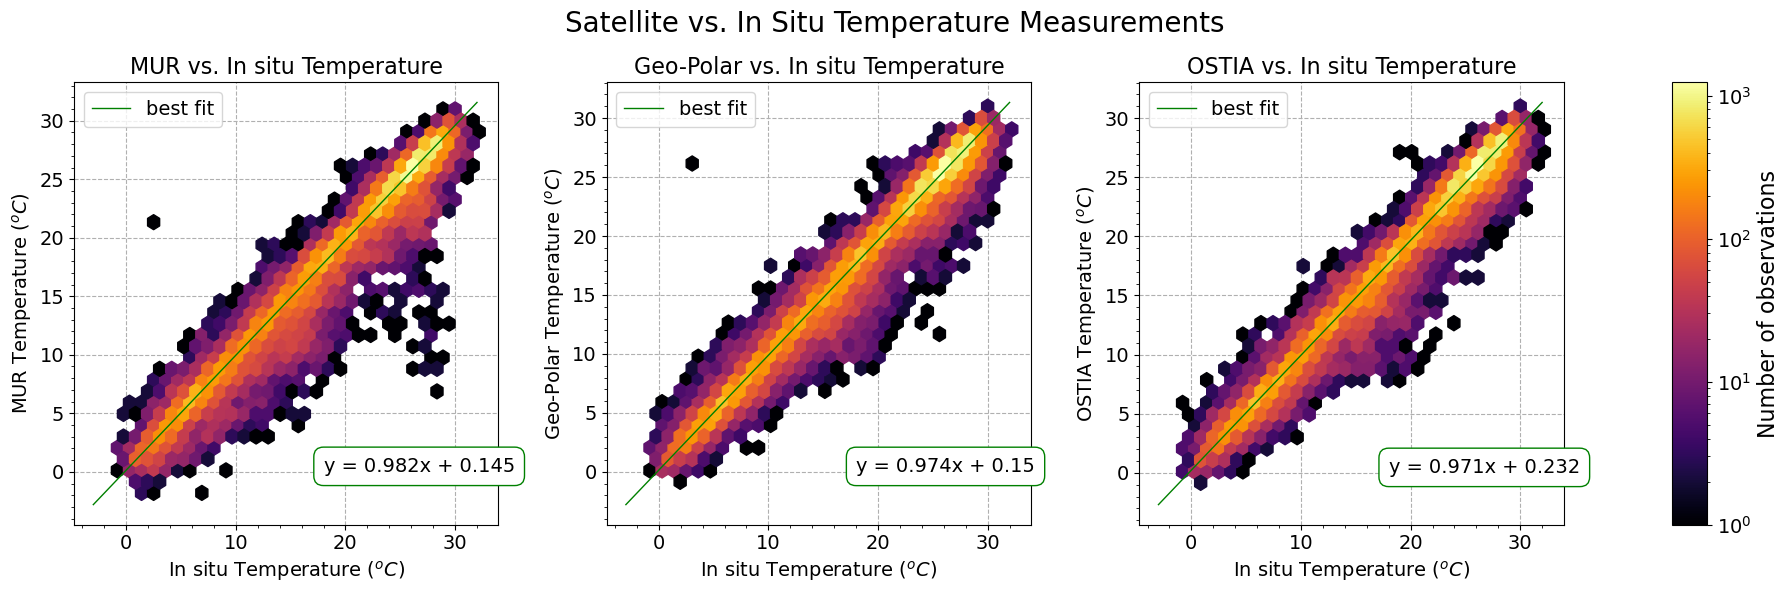

In [81]:
# Create a plot with 3 grids for the data and one grid for the colorbar
gridspec = {'width_ratios': [1.2, 1.2, 1.2, 0.1]}
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 6), gridspec_kw=gridspec)
fig.suptitle('Satellite vs. In Situ Temperature Measurements', size=20)

# Set properties for box around line of best fit
bbox_props = {'boxstyle': 'round', 'facecolor': 'white', 'pad': 0.5, 
              'edgecolor': 'green'}

# Add MUR heatmap
mur_plot = ax1.hexbin(x_mur, y_mur, gridsize=30, bins='log', cmap='inferno', 
                      extent=(xmin, xmax, ymin, ymax))
# Add MUR best fit line
ax1.plot([-3, 32], [mx_plus_b(-3, mur_slope, mur_inter), 
                     mx_plus_b(32, mur_slope, mur_inter)], 
         color='green', label='best fit', linewidth=1)
ax1.set_ylabel('MUR Temperature ($^oC$)', fontsize=14)
ax1.set_title('MUR vs. In situ Temperature', size=16)
ax1.text(18, 0, 'y = {m}x + {b}'.format(m=mur_slope.round(3), 
                                    b=mur_inter.round(3)), bbox=bbox_props,
                                    fontdict={'fontsize': 14})

# Add Geo-Polar heatmap
geop_plot = ax2.hexbin(x_geop, y_geop, gridsize=30, bins='log', cmap='inferno',
                      extent=(xmin, xmax, ymin, ymax))
# Add Geo-Polar best fit line
ax2.plot([-3, 32], [mx_plus_b(-3, geopolar_slope, geopolar_inter), 
                     mx_plus_b(32, geopolar_slope, geopolar_inter)], 
         color='green', label='best fit', linewidth=1)
ax2.set_ylabel('Geo-Polar Temperature ($^oC$)', fontsize=14)
ax2.set_title('Geo-Polar vs. In situ Temperature', fontsize=16)
ax2.text(18, 0, 'y = {m}x + {b}'.format(m=geopolar_slope.round(3), 
                                    b=geopolar_inter.round(3)), bbox=bbox_props,
                                        fontdict={'fontsize': 14})

# Add OSTIA heatmap
ost_plot = ax3.hexbin(x_ostia, y_ostia, gridsize=30, bins='log', cmap='inferno',
                      extent=(xmin, xmax, ymin, ymax))
# Add OSTIA best fit line
ax3.plot([-3, 32], [mx_plus_b(-3, ostia_slope, ostia_inter), 
                     mx_plus_b(32, ostia_slope, ostia_inter)], 
         color='green', label='best fit', linewidth=1)
ax3.set_ylabel('OSTIA Temperature ($^oC$)', fontsize=14)
ax3.set_title('OSTIA vs. In situ Temperature', size=16)
ax3.text(18, 0, 'y = {m}x + {b}'.format(m=ostia_slope.round(3), 
                                    b=ostia_inter.round(3)), bbox=bbox_props,
                                    fontdict={'fontsize': 14})


# Standardize axes settings
for ax in (ax1, ax2, ax3):
    ax.legend(loc="upper left", fontsize=14)
    # label the x axis
    ax.set_xlabel('In situ Temperature ($^oC$)', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.minorticks_on()
    # add gridlines
    ax.set_axisbelow(True)
    ax.grid(linestyle='--', linewidth=0.8)

# Add shared colorbar
cb = fig.colorbar(geop_plot, cax=ax4)
cb.set_label('Number of observations', fontsize=16)
cb.ax.tick_params(labelsize=14)

# Turn back on for SST Values
fig.tight_layout()

if SAVE_FIGS:
    plt.savefig(REPO_ROOT / 'figures/validation_analysis' / 
                'satellite_validation_raw_hexplot.jpeg', 
                bbox_inches='tight', dpi=700)


### SST Anomaly

In [82]:
# Find min/max values to use consistently across all three subplots
ymax = wq_anom[['anom_geopolar', 'anom_mur', 'anom_ostia']].max().max()
ymin = wq_anom[['anom_geopolar', 'anom_mur', 'anom_ostia']].min().min()

xmax = wq_anom.anom_cbp.max()
xmin = wq_anom.anom_cbp.min()

print(xmin, xmax, ymin, ymax)

-7.79583 8.65 -15.45756 5.8412


In [83]:
# Define shorter names for the input data
x_geop = geopanom_nonan.anom_cbp
y_geop = geopanom_nonan.anom_geopolar

x_mur = muranom_nonan.anom_cbp
y_mur = muranom_nonan.anom_mur

x_ostia = ostiaanom_nonan.anom_cbp
y_ostia = ostiaanom_nonan.anom_ostia

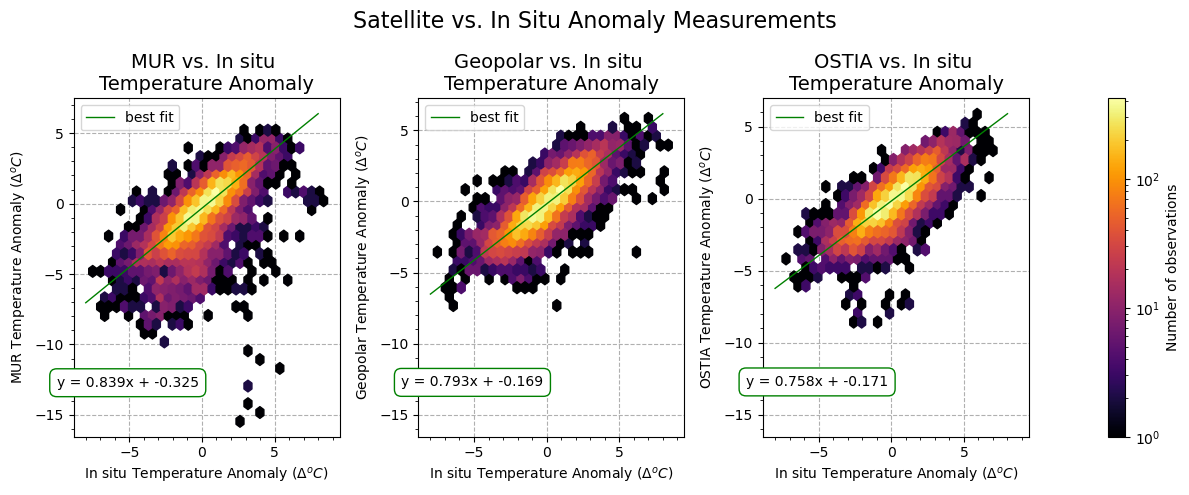

In [85]:
gridspec = {'width_ratios': [1.5, 1.5, 1.5, 0.1]}
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 5), gridspec_kw=gridspec)
fig.suptitle('Satellite vs. In Situ Anomaly Measurements', size=16)

bbox_props = {'boxstyle': 'round', 'facecolor': 'white',
             'pad': 0.5, 'edgecolor': 'green'}

# Add MUR data to axis 1
mur_plot = ax1.hexbin(x_mur, y_mur, gridsize=30, bins='log', cmap='inferno', 
                      extent=(xmin, xmax, ymin, ymax))
# plot the line of linear fit
ax1.plot([-8, 8], [mx_plus_b(-8, muranom_slope, muranom_inter), 
                     mx_plus_b(8, muranom_slope, muranom_inter)], 
         color='green', label='best fit', linewidth=1)
ax1.set_ylabel('MUR Temperature Anomaly ($\Delta^oC$)')
ax1.set_title('MUR vs. In situ \nTemperature Anomaly', size=14)
ax1.text(-10, -13, 'y = {m}x + {b}'.format(m=muranom_slope.round(3), 
                                    b=muranom_inter.round(3)), bbox=bbox_props)

# Add Geo-Polar data to axis 2
geop_plot = ax2.hexbin(x_geop, y_geop, gridsize=30, bins='log', cmap='inferno',
                      extent=(xmin, xmax, ymin, ymax))
# plot the line of linear fit
ax2.plot([-8, 8], [mx_plus_b(-8, geopanom_slope, geopanom_inter), 
                     mx_plus_b(8, geopanom_slope, geopanom_inter)], 
         color='green', label='best fit', linewidth=1)
ax2.set_ylabel('Geo-Polar Temperature Anomaly ($\Delta^oC$)')
ax2.set_title('Geo-Polar vs. In situ \nTemperature Anomaly', size=14)
ax2.text(-10, -13, 'y = {m}x + {b}'.format(m=geopanom_slope.round(3), 
                                    b=geopanom_inter.round(3)), bbox=bbox_props)

# Add OSTIA data to axis 3
ostia_plot = ax3.hexbin(x_ostia, y_ostia, gridsize=30, bins='log', cmap='inferno',
                      extent=(xmin, xmax, ymin, ymax))
# plot the line of linear fit
ax3.plot([-8, 8], [mx_plus_b(-8, ostiaanom_slope, ostiaanom_inter), 
                     mx_plus_b(8, ostiaanom_slope, ostiaanom_inter)], 
         color='green', label='best fit', linewidth=1)
ax3.set_ylabel('OSTIA Temperature Anomaly ($\Delta^oC$)')
ax3.set_title('OSTIA vs. In situ \nTemperature Anomaly', size=14)
ax3.text(-10, -13, 'y = {m}x + {b}'.format(m=ostiaanom_slope.round(3), 
                                    b=ostiaanom_inter.round(3)), bbox=bbox_props)

# Standardize axes settings
for ax in (ax1, ax2, ax3):
    ax.legend(loc="upper left")
    # label the x axis
    ax.set_xlabel('In situ Temperature Anomaly ($\Delta^oC$)')
    ax.minorticks_on()
    # add gridlines
    ax.set_axisbelow(True)
    ax.grid(linestyle='--', linewidth=0.8)

# Add shared colorbar
cb = fig.colorbar(geop_plot, cax=ax4)
cb.set_label('Number of observations')

# Turn back on for SST Values
fig.tight_layout()

if True:
    plt.savefig(REPO_ROOT / 'figures/validation_analysis' /
                'satellite_validation_anomaly_hexplot.jpeg', 
                bbox_inches='tight', dpi=700)


## Spatial Distribution of SST Error

Create geodataframe with average values at each station location

In [86]:
# OLD VERSION
# temps_mean = wq_sst.groupby(['Latitude', 'Longitude']) \
#         .mean(numeric_only=True).reset_index()
# NEW VERSION
temps_mean = wq_sst.groupby(['Station']) \
        .mean(numeric_only=True).reset_index()

In [87]:
temps_mean_gpd = gpd.GeoDataFrame(
    temps_mean, geometry=gpd.points_from_xy(
        temps_mean['Longitude'], temps_mean['Latitude']
    ), 
    crs='epsg:4326'
)

In [88]:
# fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()})

# fig.set_size_inches(8, 6)

# for ax in axes:
#     # Add background features
#     ax.add_feature(cfeature.COASTLINE, alpha=0.3)
#     ax.add_feature(cfeature.BORDERS, linestyle=':')
#     ax.add_feature(cfeature.LAND, alpha=0.5)
#     ax.add_feature(cfeature.RIVERS)
    
#     ax.set_extent([-77.5, -75.4, 36.6, 39.7])

#     # Add and format gridlines. Remove top and right labels
#     gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                       linewidth=1, color='gray', alpha=0.2, linestyle='--')
#     gl.top_labels, gl.right_labels = False, False
#     gl.xlabel_style = {'size': 10}
#     gl.ylabel_style = {'size': 10}

# # Add Geo-Polar mean error
# temps_mean_gpd.plot(ax=axes[0], column='geopolar_err', markersize=7, cmap='bwr',
#                     vmin=-4, vmax=4, edgecolor='black', linewidth=0.2)
# axes[0].set_title('Geo-Polar SST - Validation SST', size=12)

# # Add MURR mean error
# temps_mean_gpd.plot(ax=axes[1], column='mur_err', markersize=7, cmap='bwr', legend=True, 
#                     legend_kwds={'label': "SST Error (Satellite - Validation) [$^oC$]", 
#                                  'extend': 'both'}, 
#                     vmin=-6, vmax=6, edgecolor='black', linewidth=0.2)
# axes[1].set_title('MUR SST - Validation SST', size=12)

# fig.suptitle('Satellite SST Error', size=15, ha='center')

# plt.tight_layout()

# # save
# if SAVE_FIGS:
#     plt.savefig(REPO_ROOT /'figures/validation_analysis/sst_error_spatial_distribution.png', 
#                 dpi=700, bbox_inches='tight')

Adding OSTIA

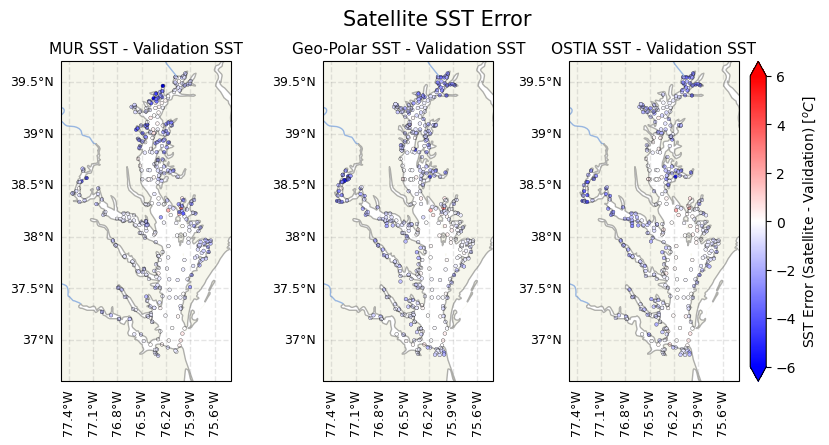

In [127]:
gs = GridSpec(1, 4, width_ratios=(1, 1, 1, 0.1))
gs.update(top=.85, bottom=0.05, left=0.05, right=.95, hspace=0.2, wspace=0.2)

f = plt.figure(figsize=(9, 4))

f.suptitle('Satellite SST Error', size=15, ha='center')

# initialize the cartopy-axes
axes = [f.add_subplot(g, projection=ccrs.PlateCarree()) for g in (gs[0], gs[1], gs[2])]

for ax in axes:
    # Add background features
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    
    ax.set_extent([-77.5, -75.4, 36.6, 39.7])

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False
    gl.xlabel_style = {'size': 9, 'rotation': 90}
    gl.ylabel_style = {'size': 9}

# Add MUR mean error
temps_mean_gpd.plot(ax=axes[0], column='mur_err', markersize=7, cmap='bwr', 
                    vmin=-6, vmax=6, edgecolor='black', linewidth=0.2)
axes[0].set_title('MUR SST - Validation SST', size=11)

# Add Geo-Polar mean error
temps_mean_gpd.plot(
    ax=axes[1], column='geopolar_err', markersize=7, cmap='bwr', vmin=-6, vmax=6, 
    edgecolor='black', linewidth=0.2,
)
axes[1].set_title('Geo-Polar SST - Validation SST', size=11)

# Add OSTIA mean error
ostia_plot = temps_mean_gpd.plot(ax=axes[2], column='ostia_err', markersize=7, cmap='bwr', 
                    vmin=-6, vmax=6, edgecolor='black', linewidth=0.2,
                    legend=True, 
    legend_kwds={'label': "SST Error (Satellite - Validation) [$^oC$]", 'extend': 'both'})
axes[2].set_title('OSTIA SST - Validation SST', size=11)

# save
if SAVE_FIGS:
    plt.savefig(
        REPO_ROOT / 'figures/validation_analysis' / 
        'sst_error_spatial_distribution.png', dpi=1000, bbox_inches='tight'
    )

## Long term trend in Anomaly error

In [90]:
anoms_mean = wq_anom.groupby(['Station']) \
        .mean(numeric_only=True).reset_index()

In [91]:
anoms_mean_gpd = gpd.GeoDataFrame(
    anoms_mean, geometry=gpd.points_from_xy(
        anoms_mean['Longitude'], anoms_mean['Latitude']
    ), 
    crs='epsg:4326'
)

In [92]:
def get_slope(df):
    '''
    Slope of the long term trend in geopolar error.
    Units unknown a.t.m.
    '''
    # print(len(df))
    x = df.SampleDate.apply(lambda x: x.toordinal())
    y = df.geopanom_err
    # Slope of long term trend
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    # Multiply by 365 so units are degrees / year not degrees / day
    df['slope'] = slope * 365
    if p_value >= 0.05:
        df['slope'] = np.nan
    # Mean
    df['mean'] = df.geopanom_err.mean()
    # STD
    df['std'] = df.geopanom_err.std()
    # Skew
    df['skew'] = scipy.stats.skew(df.geopanom_err)
    # kurtosis
    df['kurt'] = scipy.stats.kurtosis(df.geopanom_err)
    # 95th percentile
    df['95th'] = df.geopanom_err.quantile(0.95)
    return df

In [93]:
slopes = wq_anom.groupby(['Station'], group_keys=True).apply(get_slope)

In [94]:
stats_gpd = gpd.GeoDataFrame(
    slopes, geometry=gpd.points_from_xy(slopes.Longitude, slopes.Latitude), crs="EPSG:4326"
)

In [95]:
std = wq_anom.groupby(['Station', wq_anom.SampleDate.dt.month]).std(numeric_only=True) \
.groupby(['Station']).mean().reset_index()

In [96]:
std_gpd = gpd.GeoDataFrame(
    std, geometry=gpd.points_from_xy(std.Longitude, std.Latitude), crs="EPSG:4326"
)

In [97]:
print('Geopolar max/min:', anoms_mean_gpd.geopanom_err.max(), anoms_mean_gpd.geopanom_err.min(), 
     anoms_mean_gpd.geopanom_err.median(), anoms_mean_gpd.geopanom_err.std())
# print('MUR max/min:', temps_mean_gpd.mur_diff.max(), temps_mean_gpd.mur_diff.min(),
#      temps_mean_gpd.mur_diff.median(), temps_mean_gpd.mur_diff.std())

Geopolar max/min: -0.06306429078014184 -0.3637306687898089 -0.18503676375404532 0.08498080577820566


In [98]:
# vmin, vmax = -1, 1

In [99]:
# norm = matplotlib.colors.SymLogNorm(linthresh=1, vmin=-5, vmax=5, base=10)

In [100]:
anoms_mean_gpd

,Station,Latitude,Longitude,anom_cbp,anom_geopolar,anom_mur,anom_ostia,geopanom_err,muranom_err,ostiaanom_err,geometry
0,CB2.1,39.44149,-76.02599,3.367003e-07,-0.075661,-0.632174,-0.027785,-0.075662,-0.632174,-0.131545,POINT (-76.02599 39.44149)
1,CB2.2,39.34873,-76.17579,1.000000e-07,-0.109215,-0.657258,-0.098418,-0.109215,-0.657258,-0.187703,POINT (-76.17579 39.34873)
2,CB3.1,39.24950,-76.24050,-2.333333e-07,-0.139889,-0.648937,-0.118349,-0.139888,-0.648937,-0.213751,POINT (-76.24050 39.24950)
3,CB3.2,39.16369,-76.30631,-1.241830e-06,-0.178255,-0.664701,-0.171162,-0.178254,-0.664700,-0.249605,POINT (-76.30631 39.16369)
4,CB3.3C,38.99596,-76.35967,9.354839e-07,-0.219885,-0.708800,-0.199167,-0.219886,-0.708801,-0.279669,POINT (-76.35967 38.99596)
5,CB4.1C,38.82593,-76.39945,8.651089e-18,-0.191536,-0.687612,-0.178396,-0.191536,-0.687612,-0.292218,POINT (-76.39945 38.82593)
6,CB4.2C,38.64618,-76.42127,-5.501618e-07,-0.173279,-0.681469,-0.171325,-0.173278,-0.681469,-0.273529,POINT (-76.42127 38.64618)
7,CB4.3C,38.55505,-76.42794,1.516129e-06,-0.167373,-0.683888,-0.171091,-0.167374,-0.683889,-0.253930,POINT (-76.42794 38.55505)
8,CB4.4,38.41457,-76.34565,-6.451613e-08,-0.203804,-0.659744,-0.182690,-0.203804,-0.659744,-0.291654,POINT (-76.34565 38.41457)
9,CB5.1,38.31870,-76.29215,-8.090615e-07,-0.188337,-0.636377,-0.166838,-0.188336,-0.636376,-0.261854,POINT (-76.29215 38.31870)


In [101]:
std_gpd

,Station,Latitude,Longitude,anom_cbp,anom_geopolar,anom_mur,anom_ostia,geopanom_err,muranom_err,ostiaanom_err,geometry
0,CB2.1,0.0,0.0,2.102769,1.795139,2.169456,1.702125,1.662145,1.599527,1.478190,POINT (0.00000 0.00000)
1,CB2.2,0.0,0.0,1.948809,1.784100,2.173562,1.724708,1.410645,1.483838,1.304638,POINT (0.00000 0.00000)
2,CB3.1,0.0,0.0,1.901478,1.763083,2.153282,1.721616,1.173237,1.397770,1.196756,POINT (0.00000 0.00000)
3,CB3.2,0.0,0.0,1.863264,1.822821,2.177604,1.793491,1.020844,1.354840,1.113687,POINT (0.00000 0.00000)
4,CB3.3C,0.0,0.0,1.824283,1.687733,2.089644,1.734133,0.895802,1.261172,0.969801,POINT (0.00000 0.00000)
5,CB4.1C,0.0,0.0,1.721560,1.671878,2.071106,1.724927,0.730136,1.117825,0.875795,POINT (0.00000 0.00000)
6,CB4.2C,0.0,0.0,1.699674,1.663971,2.056260,1.661149,0.588374,1.097247,0.749501,POINT (0.00000 0.00000)
7,CB4.3C,0.0,0.0,1.709394,1.655528,2.040635,1.639206,0.615348,1.151561,0.746292,POINT (0.00000 0.00000)
8,CB4.4,0.0,0.0,1.670932,1.633319,1.960636,1.602235,0.548317,1.075926,0.708113,POINT (0.00000 0.00000)
9,CB5.1,0.0,0.0,1.673296,1.615266,1.939734,1.592893,0.556945,1.098831,0.698811,POINT (0.00000 0.00000)


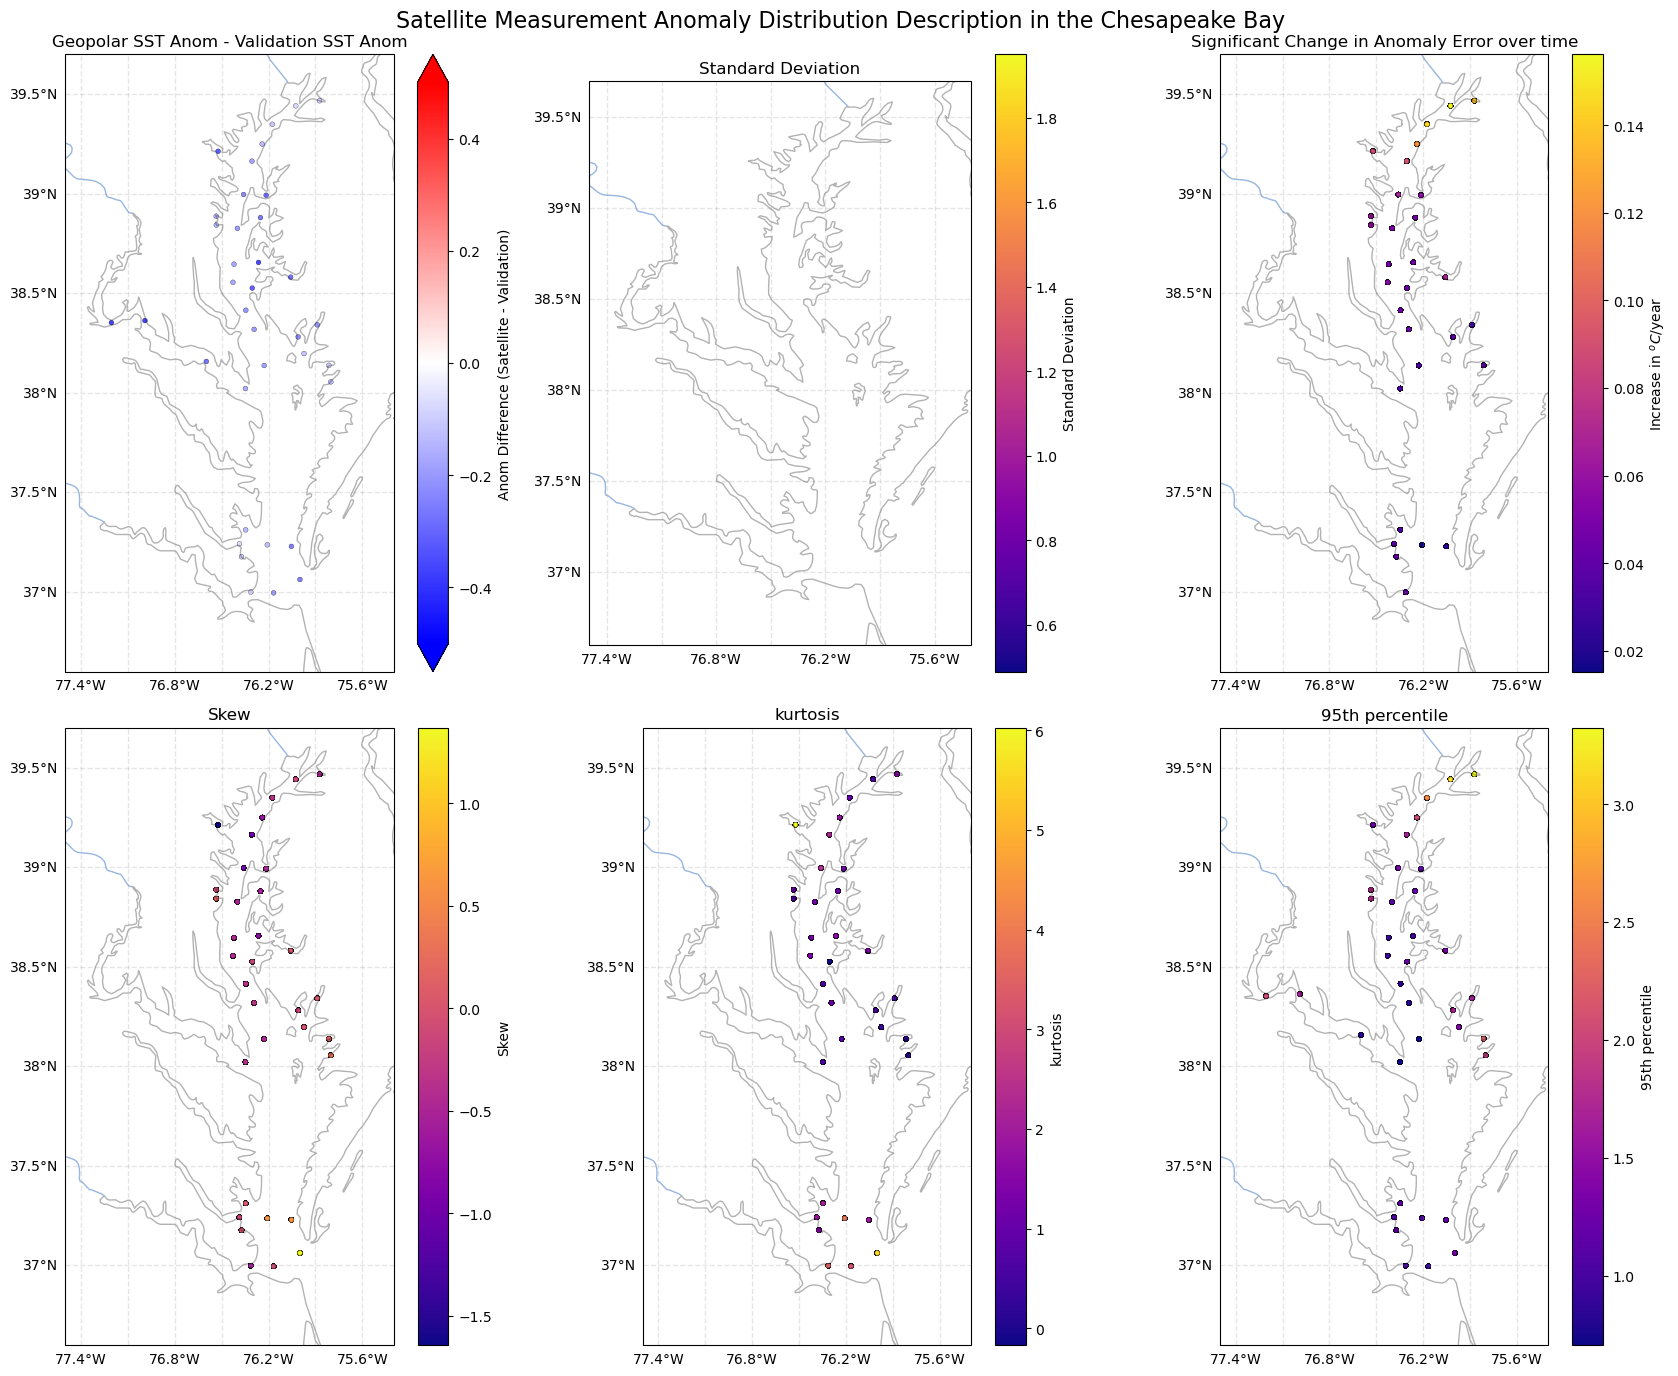

In [102]:
fig, axes = plt.subplots(2, 3, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(17, 14)
# fig.tight_layout()
fig.suptitle('Satellite Measurement Anomaly Distribution Description in the Chesapeake Bay', size=16)
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# my_cmap = matplotlib.cm.get_cmap('viridis')
# my_cmap.set_bad('black')

for ax in axes.flatten():
    # Add background features
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.RIVERS)
    # ax.coastlines()

    ax.set_extent([-77.5, -75.4, 36.6, 39.7])

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False

# Add mean error
anoms_mean_gpd.plot(ax=axes[0, 0], column='geopanom_err', markersize=12, cmap='bwr', legend=True, 
                    legend_kwds={'label': "Anom Difference (Satellite - Validation)", 'extend': 'both'}, 
                    vmin=-0.5, vmax=0.5, edgecolor='black', linewidth=0.2)
axes[0, 0].set_title('Geopolar SST Anom - Validation SST Anom', size=12)

# Standard Deviation
std_gpd.plot(ax=axes[0, 1], column='geopanom_err', markersize=12, cmap='plasma',
                legend=True,
                    legend_kwds={'label': "Standard Deviation"}, 
                    edgecolor='black', linewidth=0.2)
axes[0, 1].set_title('Standard Deviation', size=12)

# Add long term trend slope
# Can't get pandas to show nan values. Maybe set to 0 then change colormap?
stats_gpd.plot(ax=axes[0, 2], column='slope', markersize=12, cmap='plasma',
                legend=True,
                    legend_kwds={'label': "Increase in $^oC$/year"}, 
                    edgecolor='black', linewidth=0.2)
axes[0, 2].set_title('Significant Change in Anomaly Error over time', size=12)


# Skew
stats_gpd.plot(ax=axes[1, 0], column='skew', markersize=12, cmap='plasma',
                legend=True,
                    legend_kwds={'label': "Skew"}, 
                    edgecolor='black', linewidth=0.2)
axes[1, 0].set_title('Skew', size=12)

# Kurtosis
stats_gpd.plot(ax=axes[1, 1], column='kurt', markersize=12, cmap='plasma',
                legend=True,
                    legend_kwds={'label': "kurtosis"}, 
                    edgecolor='black', linewidth=0.2)
axes[1, 1].set_title('kurtosis', size=12)

# 95th Percentile
stats_gpd.plot(ax=axes[1, 2], column='95th', markersize=12, cmap='plasma',
                legend=True,
                    legend_kwds={'label': "95th percentile"}, 
                    edgecolor='black', linewidth=0.2)
axes[1, 2].set_title('95th percentile', size=12)


plt.tight_layout()

# save
if SAVE_FIGS:
    plt.savefig(REPO_ROOT /'figures/validation_analysis/map_distribution_statistics.png', 
                dpi=400, bbox_inches='tight')

Significant Time increases by spatial location

In [103]:
def trend_calc(df):
    '''
    When grouping by lat/long aggregate the anomalies by sorting in time and calculating
    returning True/False based on if there is a statistically significant change in 
    MeasureAnomaly over time
    '''
    df = df.sort_values('SampleDate')
    df = df[~df.geopolar_err.isnull()]
    # print('IS NULL?', df.SampleDate.apply(lambda x: x.toordinal()))
    x = df.SampleDate.apply(lambda x: x.toordinal())
    y = df.geopolar_err.values
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    print(slope, intercept, r_value, p_value, std_err)
    plt.plot(x, y)
    plt.show()
    return slope

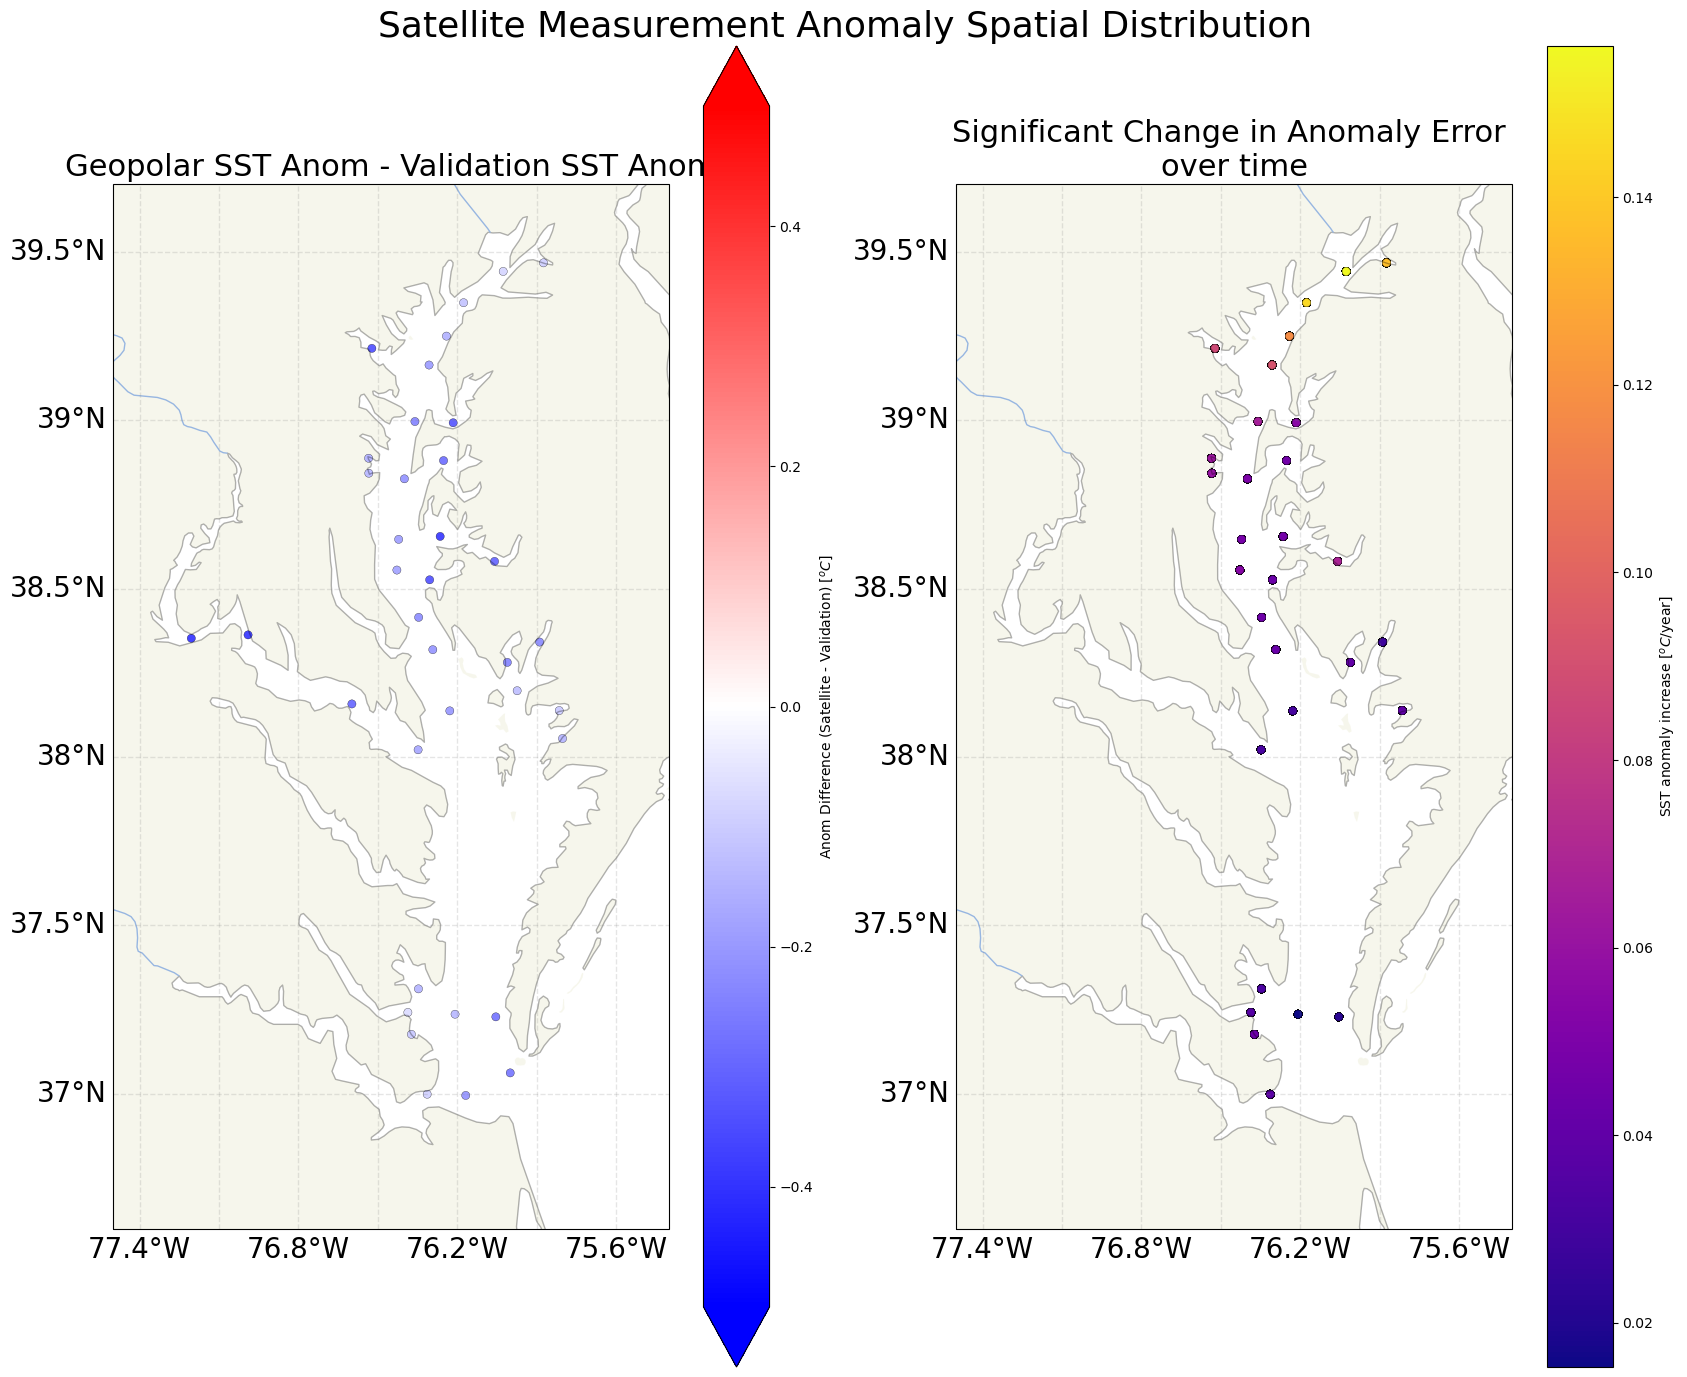

In [104]:
fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(17, 14)
# fig.tight_layout()
fig.suptitle('Satellite Measurement Anomaly Spatial Distribution', size=26)
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# my_cmap = matplotlib.cm.get_cmap('viridis')
# my_cmap.set_bad('black')

for ax in axes.flatten():
    # Add background features
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    # ax.coastlines()
    # Put a background image on for nice sea rendering.
    # ax.stock_img()

    ax.set_extent([-77.5, -75.4, 36.6, 39.7])

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style = {'size': 20}

# Add mean error
anoms_mean_gpd.plot(ax=axes[0], column='geopanom_err', markersize=35, cmap='bwr', legend=True, 
                    legend_kwds={'label': "Anom Difference (Satellite - Validation) [$^oC$]", 
                                 'extend': 'both'}, 
                    vmin=-0.5, vmax=0.5, edgecolor='black', linewidth=0.2)
axes[0].set_title('Geopolar SST Anom - Validation SST Anom', size=22)

# Add long term trend slope
# Can't get pandas to show nan values. Maybe set to 0 then change colormap?
stats_gpd.plot(ax=axes[1], column='slope', markersize=35, cmap='plasma',
                legend=True,
                    legend_kwds={'label': "SST anomaly increase [$^oC$/year]"}, 
                    edgecolor='black', linewidth=0.2)
axes[1].set_title('Significant Change in Anomaly Error \nover time', size=22)

plt.tight_layout()

# save
if SAVE_FIGS:
    plt.savefig(REPO_ROOT / 'figures/validation_analysis/map_distribution_statistics_shorter.png', 
                dpi=400, bbox_inches='tight')

In [105]:
inc_anom_err = stats_gpd[['slope', 'Latitude', 'Longitude', 'geometry']]

In [106]:
zones = gpd.read_file(
    REPO_ROOT / 'data' / 'chesapeake_traditional_zones.geojson'
)

In [107]:
zones

,id,name,geometry
0,0,upper,"MULTIPOLYGON (((-75.92652 38.84146, -76.07321 ..."
1,2,lower,"MULTIPOLYGON (((-75.97078 37.18116, -76.00552 ..."
2,1,middle,"MULTIPOLYGON (((-75.92652 38.84146, -75.80979 ..."


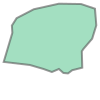

In [108]:
zones[zones.name == 'upper'].geometry.iloc[0]

In [109]:
upper_err = inc_anom_err[inc_anom_err.within(zones[zones.name == 'upper'].geometry.iloc[0])]
mid_err = inc_anom_err[inc_anom_err.within(zones[zones.name == 'middle'].geometry.iloc[0])]
lower_err = inc_anom_err[inc_anom_err.within(zones[zones.name == 'lower'].geometry.iloc[0])]

In [110]:
print(upper_err.slope.mean())
print(mid_err.slope.mean())
print(lower_err.slope.mean())

0.09016112236141012
0.04359903744577354
0.03153172717609564


In [111]:
upper_err = upper_err.groupby('Station').mean()

/var/folders/nb/y7dp0ct55_58hrhrhlz5vbkm0000gn/T/ipykernel_5146/1083930506.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  upper_err = upper_err.groupby('Station').mean()


In [112]:
upper_err = upper_err.reset_index()

<AxesSubplot: >

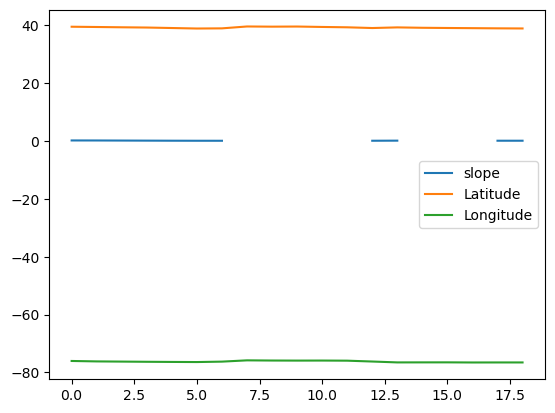

In [113]:
upper_err.plot()

AttributeError: Line2D.set() got an unexpected keyword argument 'legend_kwds'

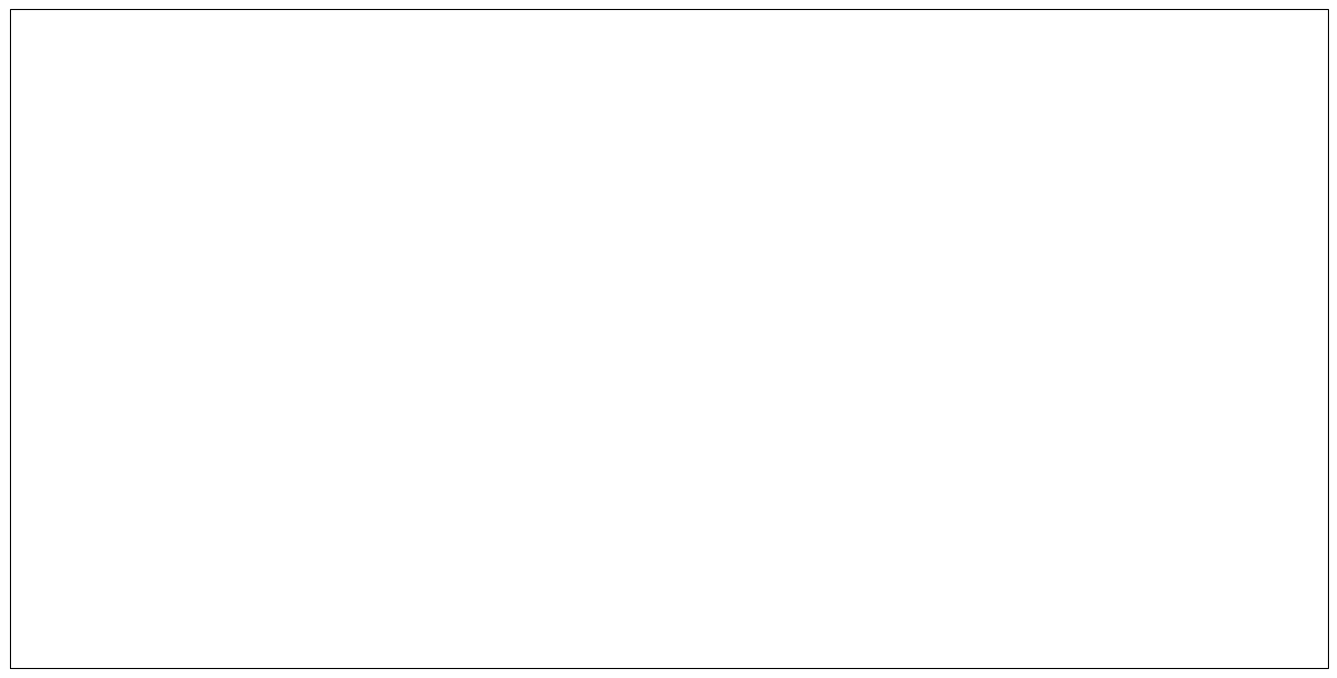

In [114]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(17, 14)
# fig.tight_layout()
# fig.suptitle('Satellite Measurement Anomaly Spatial Distribution', size=26)
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# my_cmap = matplotlib.cm.get_cmap('viridis')
# my_cmap.set_bad('black')

for ax in axes.flatten():
    # Add background features
    ax.add_feature(cfeature.COASTLINE, alpha=0.3)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    # ax.coastlines()
    # Put a background image on for nice sea rendering.
    # ax.stock_img()

    ax.set_extent([-77.5, -75.4, 36.6, 39.7])

    # Add and format gridlines. Remove top and right labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.top_labels, gl.right_labels = False, False
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style = {'size': 20}


# Add long term trend slope
# Can't get pandas to show nan values. Maybe set to 0 then change colormap?
upper_err.plot(ax=ax, column='slope', markersize=35, cmap='plasma',
                legend=True,
                    legend_kwds={'label': "SST anomaly increase [$^oC$/year]"}, 
                    edgecolor='black', linewidth=0.2)
# axes[1].set_title('Significant Change in Anomaly Error \nover time', size=22)

plt.tight_layout()

# save
# if SAVE_FIGS:
#     plt.savefig(REPO_ROOT / 'figures/validation_analysis/map_distribution_statistics_shorter.png', 
#                 dpi=400, bbox_inches='tight')

## Hovm&#246;ller Plot for Seasonality of Error



In [115]:
def create_hovmoller_matrix(temps: pd.DataFrame, satellite_name: str) -> pd.DataFrame:
    """
    temps - pandas dataframe of ...
    satellite_name
    """
    temps = temps.set_index(pd.to_datetime(temps['SampleDate']))
    temps = temps.resample('M').mean()
    
    temps = temps[[satellite_name + '_err']]
    
    temps['month'] = temps.index.month
    temps['year'] = temps.index.year
    
    matrix = temps.pivot(index='year', columns='month')
    
    return matrix

In [116]:
# wq_sst_mur = wq_sst[~wq_sst.mur_err.isnull()]
# wq_sst_gp = wq_sst[~wq_sst.geopolar_err.isnull()]

In [117]:
matrix_geop = create_hovmoller_matrix(wq_sst[~wq_sst.geopolar_err.isnull()], 'geopolar')
matrix_mur = create_hovmoller_matrix(wq_sst[~wq_sst.mur_err.isnull()], 'mur')

/var/folders/nb/y7dp0ct55_58hrhrhlz5vbkm0000gn/T/ipykernel_5146/3455120612.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temps = temps.resample('M').mean()
/var/folders/nb/y7dp0ct55_58hrhrhlz5vbkm0000gn/T/ipykernel_5146/3455120612.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temps = temps.resample('M').mean()


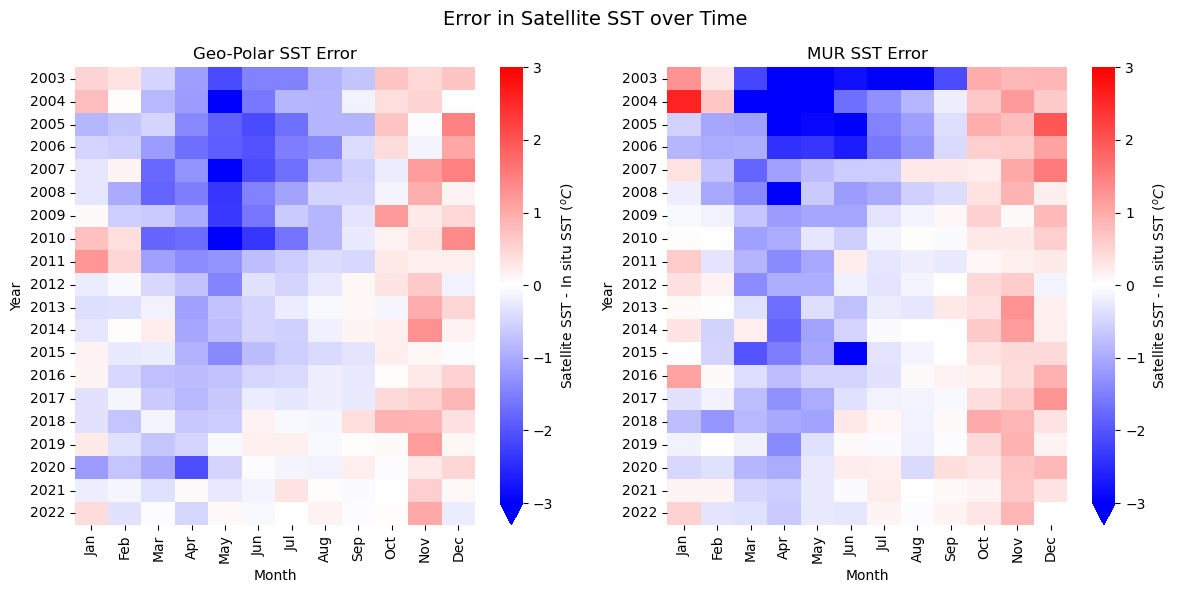

In [118]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 6)
fig.suptitle('Error in Satellite SST over Time', size=14)

vmin, vmax = -3, 3
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 
          'Oct', 'Nov', 'Dec']

bwr_badgrey = plt.cm.get_cmap("bwr").copy()
bwr_badgrey.set_bad('grey')

sns.heatmap(matrix_geop, ax=ax1, cmap=bwr_badgrey, vmin=vmin, vmax=vmax,
            cbar_kws={'label': 'Satellite SST - In situ SST ($^oC$)', 'extend': 'min'})
ax1.set_xticklabels(months, rotation=90)
ax1.set_xlabel('Month')
ax1.set_ylabel('Year')
ax1.set_title('Geo-Polar SST Error')

# # Create a Rectangle patch
# rect = patches.Rectangle((3, 2021), 40, 1000, linewidth=10, edgecolor='black', facecolor='black')

# # Add the patch to the Axes
# ax1.add_patch(rect)

# Format the colorbar
# cmap = plt.cm.twilight
# norm = matplotlib.colors.BoundaryNorm(range(1, 15), cmap.N)
# sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
# colors=[]
# for i in range(12):
#     if geo_pvals.iloc[i] > 0.05:
#         # append light grey if the trend is not significant
#         colors.append((0.878, 0.878, 0.878, 1))
#     else:
#         colors.append(sm.to_rgba(i+1))

sns.heatmap(matrix_mur, ax=ax2, cmap=bwr_badgrey, vmin=vmin, vmax=vmax,
            cbar_kws={'label': 'Satellite SST - In situ SST ($^oC$)', 'extend': 'min'})
ax2.set_xticklabels(months, rotation=90)
ax2.set_xlabel('Month')
ax2.set_ylabel('Year')
ax2.set_title('MUR SST Error')


plt.tight_layout()
SAVE_FIGS = True
if SAVE_FIGS:
    plt.savefig(REPO_ROOT / 'figures/supplemental_material/sst_hovmoller_error.png', 
                dpi=350, 
                bbox_inches='tight')

Create Geo-Polar SST Hovemoller plot

In [119]:
matrix_geop.min()

              month
geopolar_err  1       -1.179001
              2       -0.986037
              3       -1.821144
              4       -2.083891
              5       -3.728093
              6       -2.343980
              7       -1.678220
              8       -1.387362
              9       -0.879348
              10      -0.212746
              11      -0.120965
              12      -0.215059
dtype: float64

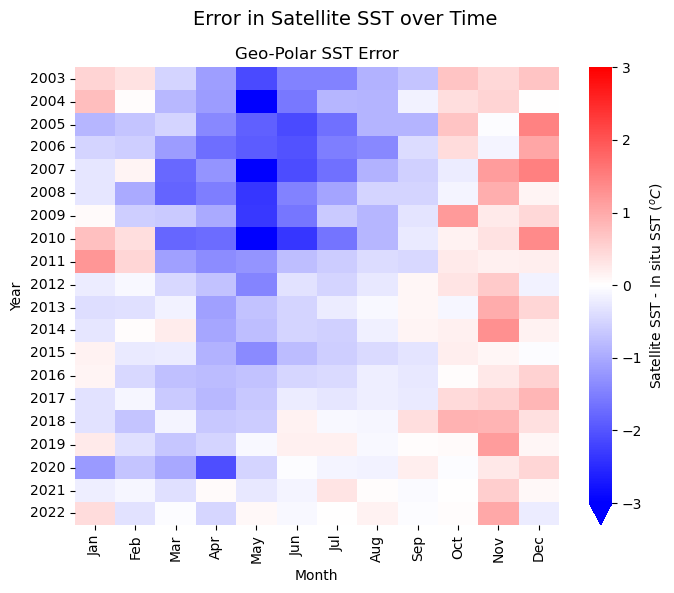

In [126]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7, 6)
fig.suptitle('Error in Satellite SST over Time', size=14)

vmin, vmax = -3, 3
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 
          'Oct', 'Nov', 'Dec']

bwr_badgrey = plt.cm.get_cmap("bwr").copy()
bwr_badgrey.set_bad('grey')

sns.heatmap(matrix_geop, ax=ax, cmap=bwr_badgrey, vmin=vmin, vmax=vmax,
            cbar_kws={'label': 'Satellite SST - In situ SST ($^oC$)', 'extend': 'min'})
ax.set_xticklabels(months, rotation=90)
ax.set_xlabel('Month')
ax.set_ylabel('Year')
ax.set_title('Geo-Polar SST Error')

plt.tight_layout()
SAVE_FIGS = True
if SAVE_FIGS:
    plt.savefig(REPO_ROOT / 'figures/validation_analysis' / 'hovmoller_ssta_error.png', 
                dpi=350, bbox_inches='tight')

<AxesSubplot: xlabel='None,month'>

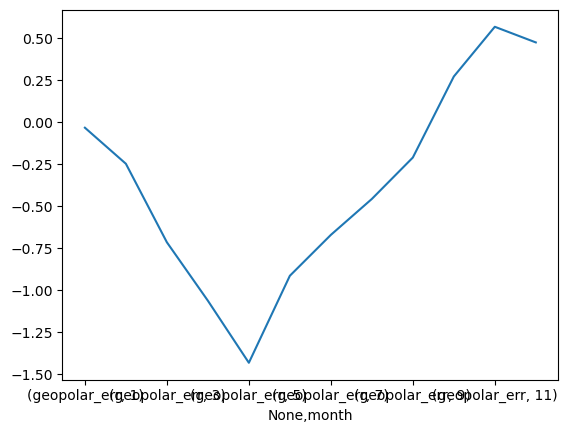

In [121]:
matrix_geop.mean('rows').plot()

## Delete all below

### Quantifying Long Term trend by month

In [73]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(range(20),
                                                                     matrix_geop.mean(axis=1))

print('Geopolar: slope', slope.round(3), 'deg C per year', 'intercept', intercept, 'r squared', r_value**2, 'p_value', p_value)

Geopolar: slope 0.041 deg C per year intercept -0.6049768747510146 r squared 0.6659353578688084 p_value 1.1499917947695823e-05


In [74]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(range(20),
    matrix_mur.mean(axis=1))

print('MUR: slope', slope.round(3), 'deg C per year', 'intercept', intercept, 'r squared', r_value**2, 'p_value', p_value)

MUR: slope 0.063 deg C per year intercept -0.8531990146923916 r squared 0.5920944421655238 p_value 7.297419456249691e-05


In [75]:
def linearregression(row):
    _, _, r_value, p_value, _ = scipy.stats.linregress(range(20), row)
    row['p_value'] = p_value
    # return pd.DataFrame({'p_value': p_value, 'other': 0})
    return p_value

In [76]:
def significant_slopes(row):
    slope, _, r_value, p_value, _ = scipy.stats.linregress(range(20), row)
    # if p_value > 0.05:
    #     slope = np.nan
    # return pd.DataFrame({'p_value': p_value, 'other': 0})
    return slope

In [77]:
geo_pvals = matrix_geop.apply(linearregression, axis=0)
geo_slope = matrix_geop.apply(significant_slopes, axis=0)

In [78]:
mur_pvals = matrix_mur.apply(linearregression, axis=0)
mur_slope = matrix_mur.apply(significant_slopes, axis=0)

In [79]:
geo_pvals.index = geo_pvals.index.droplevel(0)
mur_pvals.index = mur_pvals.index.droplevel(0)

geo_slope.index = geo_slope.index.droplevel(0)
mur_slope.index = mur_slope.index.droplevel(0)

In [80]:
all_pvals = pd.concat([geo_pvals, mur_pvals], axis=1, keys=['geopolar', 'mur'])
all_slopes = pd.concat([geo_slope, mur_slope], axis=1, keys=['geopolar', 'mur'])

In [81]:
geo_slope = pd.DataFrame(geo_slope)
geo_slope['significant'] = geo_slope > 0.05

In [82]:
geo_slope = geo_slope.rename({0: 'error_slope'}, axis=1)

In [83]:
geo_slope

,error_slope,significant
month,,
1,-0.016449,False
2,-0.013679,False
3,0.041951,False
4,0.042326,False
5,0.156803,True
6,0.122671,True
7,0.093700,True
8,0.062230,True
9,0.037744,False


In [84]:
geo_pvals

month
1     4.766117e-01
2     3.962000e-01
3     6.323508e-02
4     2.274096e-02
5     1.014911e-06
6     1.022042e-06
7     5.866144e-07
8     2.472164e-07
9     6.871329e-04
10    1.880164e-01
11    1.918230e-01
12    3.976645e-02
dtype: float64

### Ploting Temporal Trends

In [86]:
cmap = plt.cm.twilight
norm = matplotlib.colors.BoundaryNorm(range(1, 15), cmap.N)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

In [87]:
# import matplotlib.patches as patches

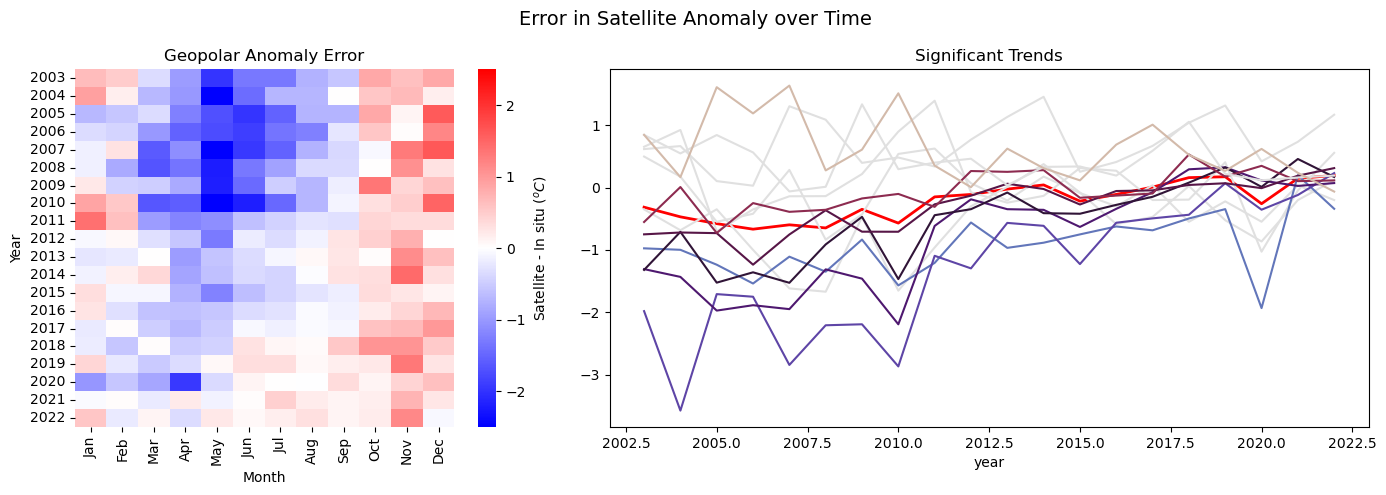

In [88]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [1, 1.6]})
fig.suptitle('Error in Satellite Anomaly over Time', size=14)

bwr_badgrey = plt.cm.get_cmap("bwr").copy()
bwr_badgrey.set_bad('grey')

sns.heatmap(matrix_geop, ax=ax1, cmap=bwr_badgrey, vmin=vmin, vmax=vmax,
            cbar_kws={'label': 'Satellite - In situ ($^oC$)'})
ax1.set_xticklabels(months, rotation=90)
ax1.set_xlabel('Month')
ax1.set_ylabel('Year')

# # Create a Rectangle patch
# rect = patches.Rectangle((3, 2021), 40, 1000, linewidth=10, edgecolor='black', facecolor='black')

# # Add the patch to the Axes
# ax1.add_patch(rect)

# Format the colorbar
cmap = plt.cm.twilight
norm = matplotlib.colors.BoundaryNorm(range(1, 15), cmap.N)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
colors=[]
for i in range(12):
    if geo_pvals.iloc[i] > 0.05:
        # append light grey if the trend is not significant
        colors.append((0.878, 0.878, 0.878, 1))
    else:
        colors.append(sm.to_rgba(i+1))

matrix_geop.mean(axis=1).plot(ax=ax2, color='red', linewidth=2, label='mean')
matrix_geop.plot(ax=ax2, color=colors, legend=False)

ax1.set_title('Geopolar Anomaly Error')
ax2.set_title('Significant Trends')


plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(REPO_ROOT /'figures/validation_analysis/hovmoller_error_withmonths.png', 
                dpi=350, bbox_inches='tight')

In [89]:
matrix_geop.min().min(), matrix_geop.max().max()

(-3.578098483615452, 1.6351247382886482)

In [97]:
matrix_mur.min().min(), matrix_mur.max().max()

(-6.1529295872490195, 2.7471384684244793)

## Error Histogram

**TODO:** What is the point of the plot? Is it to show that the distribtuion is just a bit wider/narrow in each satellite? Or is it to show that one outlier?

In [39]:
mur_mean, mur_std = wq_sst_mur.mur_diff.mean(), wq_sst_mur.mur_diff.std()
gp_mean, gp_std = wq_sst_gp.geopolar_diff.mean(), wq_sst_gp.geopolar_diff.std()

In [40]:
mur_skew, mur_kurtosis = scipy.stats.skew(wq_sst_mur.mur_diff), scipy.stats.kurtosis(wq_sst_mur.mur_diff)
gp_skew, gp_kurtosis = scipy.stats.skew(wq_sst_gp.geopolar_diff), scipy.stats.kurtosis(wq_sst_gp.geopolar_diff)

In [41]:
print('mur skew / kurtosis: ', mur_skew, mur_kurtosis)
print('geopolar skew / kurtosis: ', gp_skew, gp_kurtosis)

mur skew / kurtosis:  -1.880341587677962 10.13949413757137
geopolar skew / kurtosis:  -1.0408460932054557 6.879465342358197


In [42]:
mur_mean, mur_std

(-0.39130512331257516, 1.7685256176391038)

In [43]:
gp_mean, gp_std

(-0.37111893989183925, 1.5182878109568065)

**TODO** Can I justify this times 2000 thing?

In [44]:
# Normal Distributions
x_norm = np.linspace(-10, 10, 100)
mur_norm = [stats.norm.pdf(x, mur_mean, mur_std)*2000 for x in x_norm]
gp_norm = [stats.norm.pdf(x, gp_mean, gp_std)*2000 for x in x_norm]
# stats.norm.pdf(x, mu, sigma)

In [45]:
# fig, (ax1, ax2) = plt.subplots(1, 2)

# fig.set_size_inches(8, 3)
# fig.suptitle('Histogram of SST Anomaly for MUR and Geopolar Blended')

# wq_sst_mur.geopolar_diff.hist(ax = ax2, bins=75)
# ax2.set_title('mur value' + ' Histogram')
# # Plot normal curve
# ax2.plot(x_norm, gp_norm, linewidth=0.8)
# ax2.set_yscale('log')

# wq_sst_gp.mur_diff.hist(ax = ax1, bins=75, log=True)
# ax1.set_title('geopolar value' + ' Histogram')
# ax1.set_ylabel('Count')
# ax1.plot(x_norm, mur_norm, linewidth=0.8)
# ax1.set_yscale('log')

# for ax in (ax1, ax2):
#     # label x axis
#     ax.set_xlabel('Temperature Error ($^oC$)')
#     # standardize axes
#     # ax.set_xlim([-8, 23])
#     ax.set_ylim([0.9, 1000])
#     ax.set_xlim([-20, 26])
#     # ax.set_ylim([0.8, 10000])
#     # WHAT TO DO ABOUT GRIDLINES
#     # add minor ticks
#     # ax.xaxis.grid(which='major', color='#DDDDDD', linewidth=0.8)
#     # # Show the minor grid as well. Style it in very light gray as a thin,
#     # # dotted line.
#     ax.xaxis.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
#     ax.xaxis.set_minor_locator(AutoMinorLocator())
#     ax.grid(False)
#     # ax.axvline(0, color='black')

# plt.tight_layout()
# if SAVE_FIGS:
#     plt.savefig(os.path.join(REPO_ROOT, 'figures', 'validation_analysis/errors_histogram.png'), 
#                 dpi=400, bbox_inches='tight')

## Spatial Plots

**TODO**: figure out if there is a way to improve the resolution of the coastline, so it doesn't look like there are datapoints being taken on land.

**TODO**: Awkward spacing

Below: There are 49 anomaly validation stations spread across the bay

In [43]:
# temps_mean_gpd.groupby(['Latitude', 'Longitude']).groups

<AxesSubplot: >

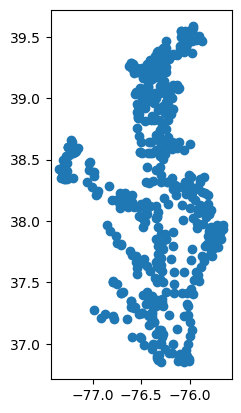

In [44]:
temps_mean_gpd.plot()

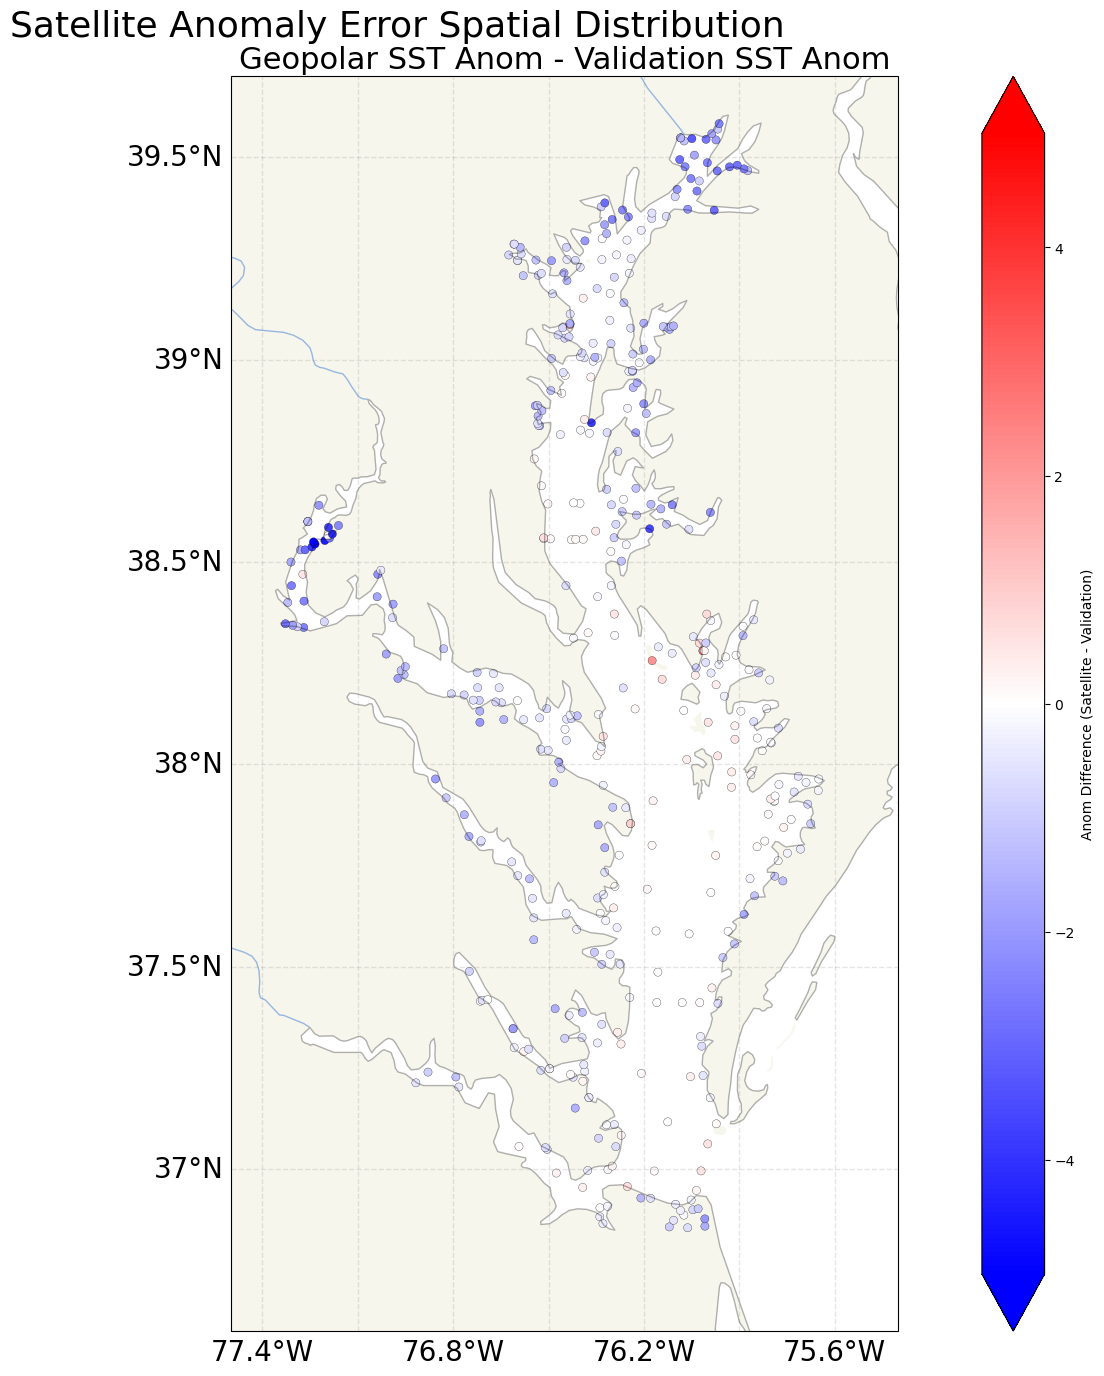

In [63]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})

fig.set_size_inches(17, 14)
# fig.tight_layout()
fig.suptitle('Satellite Anomaly Error Spatial Distribution', size=26)
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# my_cmap = matplotlib.cm.get_cmap('viridis')
# my_cmap.set_bad('black')

# Add background features
ax.add_feature(cfeature.COASTLINE, alpha=0.3)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
# ax.coastlines()
# Put a background image on for nice sea rendering.
# ax.stock_img()

ax.set_extent([-77.5, -75.4, 36.6, 39.7])

# Add and format gridlines. Remove top and right labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='--')
gl.top_labels, gl.right_labels = False, False
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

# Add mean error
temps_mean_gpd.plot(ax=ax, column='geopolar_diff', markersize=35, cmap='bwr', legend=True, 
                    legend_kwds={'label': "Anom Difference (Satellite - Validation)", 
                                 'extend': 'both'}, 
                    vmin=-5, vmax=5, edgecolor='black', linewidth=0.2)
ax.set_title('Geopolar SST Anom - Validation SST Anom', size=22)


plt.tight_layout()

# save
if SAVE_FIGS:
    plt.savefig(REPO_ROOT / 'figures/validation_analysis/map_distribution_statistics_shorter.png', 
                dpi=400, bbox_inches='tight')

In [64]:
# SAVE_FIGS = True

In [65]:
temps_mean_gpd.mur_diff.min()

-10.552001953125

Walking through p values:

Question: Does the size of the anomaly value vary over time?
Hypothesis: ...

In [67]:
# wq_sst.groupby(['Latitude', 'Longitude']).apply(trend_calc)

In [ ]:
# fig, ax = plt.subplots()
# fig.set_size_inches(6, 6)
# fig.suptitle('Error in Satellite Anomaly over Time', size=14)

# bwr_badgrey = plt.cm.get_cmap("bwr").copy()
# bwr_badgrey.set_bad('grey')

# sns.heatmap(matrix_geop, ax=ax, cmap=bwr_badgrey, vmin=vmin, vmax=vmax,
#             cbar_kws={'label': 'Satellite Anom - In situ Anom ($^oC$)'})
# ax.set_xticklabels(months, rotation=90)
# ax.set_xlabel('Month')
# ax.set_ylabel('Year')

# matrix_geop.mean(axis=1).plot(ax=ax2, color='red', linewidth=2, label='mean')
# # matrix_geop.plot(ax=ax2, color=colors, legend=False)

# ax1.set_title('Geopolar Anomaly Error')
# # ax2.set_title('Significant Trends')


# plt.tight_layout()
# if SAVE_FIGS:
#     plt.savefig(os.path.join(REPO_ROOT, 'figures/validation_analysis/hovmoller_error.png'), 
#                 dpi=350, 
#                 bbox_inches='tight')